In [388]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.constants import N_A
from scipy.optimize import fsolve
import math

In [389]:
Target_cell_number = 2e5
well_size = 150e-6
E_T_ratio = 1
sigma = well_size*N_A/Target_cell_number
synapse_gap = 25e-9
synapse_width = 10e-6
r_ab = 1.25e-8
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)
tumour_cell_IS_proportion = (synapse_width**2)/(tumour_cell_surface_area)
NK_cell_radius = 3.25e-6
NK_cell_surface_area = 4*math.pi*((NK_cell_radius)**2)
NK_cell_IS_proportion = (synapse_width**2)/NK_cell_surface_area
assay_to_synapse_conversion = (synapse_width**2*synapse_gap)/well_size
sigma_synapse = sigma*assay_to_synapse_conversion
reaction_volume1 = (2*1e3*math.pi*(r_ab**3))/3 # in L
reaction_volume2 = (2*1e3/3)*math.pi*((0.5*r_ab)**3) # in L
reaction_volume3 = (2*1e3/3)*math.pi*((2*r_ab)**3) # in L
reaction_volume_4 = (1e3/3)*math.pi*((r_ab)**3) # in L
print(tumour_cell_IS_proportion, NK_cell_IS_proportion)
t_end = 60*60*1000
t = np.geomspace(1e-10, t_end, 50)
tspan = [1e-10, t_end]

0.12433979929054326 0.7533961803166646


In [390]:
def A1_steady_state(x, Atot, k1, koff, k2, rtot):
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

In [391]:
print(sigma_synapse)

7.527675950000002


In [392]:
def R_single_cell(t, z, Ainit, rtot, kon, k2, koff):
     
     k = kon/sigma
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z[0] - z[1] 
     Ag = rtot - z[0] - 2*z[1]

     dA10 = 2*(k*Ag*A0) - koff*z[0] - (k2*Ag*z[0]/rtot) + 2*koff*z[1]
     dA11 = (k2*Ag*z[0]/rtot) - 2*koff*z[1]

     return [dA10, dA11]

def S_single_cell(t, z, Ainit, rtot, kon, k2, koff):
     
     k = kon/sigma
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z[0] - z[1] 
     Ag = rtot - z[0] - 2*z[1]

     dA10 = 2*(k*Ag*A0) - koff*z[0] - (k2*Ag*z[0]) + 2*koff*z[1]
     dA11 = (k2*Ag*z[0]) - 2*koff*z[1]

     return [dA10, dA11]

In [393]:
def R_two_cells(t, z, k1, k2, k3, k4, k5, k6, k7, k1off, k2off, rtot, rtot_fc, Atot):


    A0 = (Atot - (z[0] + z[1] + z[3] + z[4] + z[2]))
    rt = rtot- z[0] - z[3] - 2*(z[1] + z[4])
    rf = rtot_fc - z[2] - (z[3] + z[4])
    
    dA10 = 2*k1*(A0)*(rt) - k1off*z[0] - k2*z[0]*(rt/rtot) + 2*k1off*z[1] - k4*z[0]*(rf/rtot_fc) + k2off*z[3]
    dA20 = k2*z[0]*(rt/rtot) - 2*k1off*z[1] - k5*z[1]*(rf/rtot_fc) + k2off*z[4]
    dA01 = k3*(A0)*(rf) - k2off*z[2] - 2*k6*z[2]*(rt/rtot) + k1off*z[3]
    dA11 = k4*z[0]*(rf/rtot_fc) - k2off*z[3] + 2*k6*z[2]*(rt/rtot) -k1off*z[3] - k7*z[3]*(rt/rtot) + 2*k1off*z[4]
    dA21 = k5*z[1]*(rf/rtot_fc) - k2off*z[4] + k7*z[3]*(rt/rtot) - 2*k2off*z[4]
    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

def S_two_cells(t, z, k1, k2, k3, k4, k5, k6, k7, k1off, k2off, rtot_synapse, rtot_fc_synapse, Atot):


    A0 = Atot - (z[0] + z[1] + z[3] + z[4] + z[2])
    rt = rtot_synapse- z[0] - z[3] - 2*(z[1] + z[4])
    rf = rtot_fc_synapse - z[2] - (z[3] + z[4])
    
    dA10 =  2*k1*(A0)*(rt) - k1off*z[0] - k2*z[0]*(rt) + 2*0*k1off*z[1] - k4*z[0]*(rf) + 1*k2off*z[3]
    dA20 = k2*z[0]*(rt) - 2*0*k1off*z[1] - k5*z[1]*(rf) + 0*k2off*z[4]
    dA01 =  k3*(A0)*(rf) - 2*k2off*z[2] - 2*k6*1*z[2]*(rt) + k1off*1*z[3]
    dA11 = k4*z[0]*(rf) - 1*k2off*z[3] + 2*k6*1*z[2]*(rt) -k1off*1*z[3] - k7*z[3]*(rt) + 2*1*k1off*z[4]
    dA21 = k5*z[1]*(rf) - 0*k2off*z[4] + k7*z[3]*(rt) - 2*1*k1off*z[4]
    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

In [394]:
def NK_cell_model(t, z, qon, qoff, rtot, Atot, E_T_ratio):
    
    qon = qon*E_T_ratio/sigma
    r = rtot - z
    A0 = Atot - z
    dA1 = qon*r*A0 - qoff*z

    return dA1

In [395]:
kon = 1e5
qon = 6.5e3
koff = 1e-4
qoff = 4.7e-3
rtot = 1e5
rtot_fc = 2.2e5
rtot_synapse = rtot*tumour_cell_IS_proportion
rtot_fc_synapse = rtot_fc*NK_cell_IS_proportion

k1 = kon/sigma_synapse
k3 = qon/sigma_synapse

target_effective_conc1 =(rtot_synapse)*((math.pi*(r_ab**2))/(synapse_width**2))*(1/N_A)/(reaction_volume1)
k2 = target_effective_conc1*kon

target_effective_conc2 = (rtot_fc_synapse)*((math.pi*((2*r_ab)**2))/(synapse_width**2))*(1/N_A)/(reaction_volume3)
k4 = target_effective_conc2*qon

target_effective_conc3 = (rtot_fc_synapse)*((math.pi*(r_ab**2))/(synapse_width**2))*(1/N_A)/(reaction_volume1)
k5 = target_effective_conc3*qon

target_effective_conc4 = (rtot_synapse)*((math.pi*((r_ab)**2))/(synapse_width**2))*(1/N_A)/(reaction_volume3)
k6 = target_effective_conc2*kon

target_effective_conc5 = (rtot_synapse)*((math.pi*(r_ab**2)/2)/(synapse_width**2))*(1/N_A)/(reaction_volume_4)
k7 = target_effective_conc5*kon

In [396]:
target_effective_conc1 =(rtot_synapse)*((math.pi*(r_ab**2))/(synapse_width**2))*(1/N_A)/(reaction_volume1)
k2 = target_effective_conc1*kon


In [397]:
Ainit = 5e-5
t_end = 60*60*5
t = np.geomspace(1e-6, t_end, 500)
tspan = [1e-10, t_end]
target_effective_conc =(rtot)*((math.pi*(r_ab**2))/(tumour_cell_surface_area))*(1/N_A)/(reaction_volume1)
k2_single = target_effective_conc*kon
"""
D_t = 1e-14
D_f = 7.4e-14
kon=1e5
rtot_synapse = rtot*tumour_cell_IS_proportion
rtot_fc_synapse = rtot_fc*NK_cell_IS_proportion
k1 = kon/sigma_synapse
k3 = qon/sigma_synapse
k2 = 4*D_t/(tumour_cell_surface_area)
k4 = 4*D_f/(NK_cell_surface_area)   
"""
z0 = [0, 0]
synapse_area = synapse_width**2
k1 = kon/sigma_synapse
k3 = qon/sigma_synapse  
D_t = 1e-14
D_f = 7.4e-14
kon = 1e5
koff = 1e-4
rtot_synapse = rtot*tumour_cell_IS_proportion
rtot_fc_synapse = rtot_fc*NK_cell_IS_proportion
k1 = kon/sigma_synapse
k3 = qon/sigma_synapse
k2 = 4*D_t/(synapse_area)
k2_single = 4*D_t/(tumour_cell_surface_area)
k4 = 2*(D_t +D_f)/(synapse_area)   
k5 = 2*(D_t +D_f)/(synapse_area)  
k6 = 2*(D_t +D_f)/(synapse_area)  
k7 = 2*D_t/synapse_area

z = solve_ivp(S_single_cell, tspan, z0, method='BDF', t_eval=t, args=(Ainit, rtot, kon, k2_single, koff))

Atot_whole = well_size*N_A*Ainit/Target_cell_number
A1 = z.y[0]
A2 = z.y[1]

Atot_NK = Atot_whole - A1[-1] - A2[-1]

z = solve_ivp(NK_cell_model, tspan, [0], method='Radau', t_eval=t, args=(qon, qoff, rtot_fc, Atot_NK, E_T_ratio))

A01 = z.y[0]
print(A01[-1]*NK_cell_IS_proportion/rtot_fc_synapse)
A01_IC = A01[-1]*NK_cell_IS_proportion

A10_IC = A1[-1]*tumour_cell_IS_proportion
A20_IC = A2[-1]*tumour_cell_IS_proportion

Atot = A10_IC + A20_IC + A01_IC
z0 = [A10_IC, A20_IC, A01_IC, 0, 0]
    
z = solve_ivp(S_two_cells, tspan, z0, method='BDF', rtol = 1e-5, atol=1e-5, t_eval=t, args=(k1, k2, k3, k4, 0, k6, k7, koff, qoff, rtot_synapse, rtot_fc_synapse, Atot))
print(z.message)
A10 = z.y[0]
A20 = z.y[1]
A01 = z.y[2]
A11 = z.y[3]
A21 = z.y[4]
print(k6, k7, k2)

0.9857444274742412
The solver successfully reached the end of the integration interval.
0.0016799999999999996 0.00019999999999999996 0.0003999999999999999


53941.83638683641


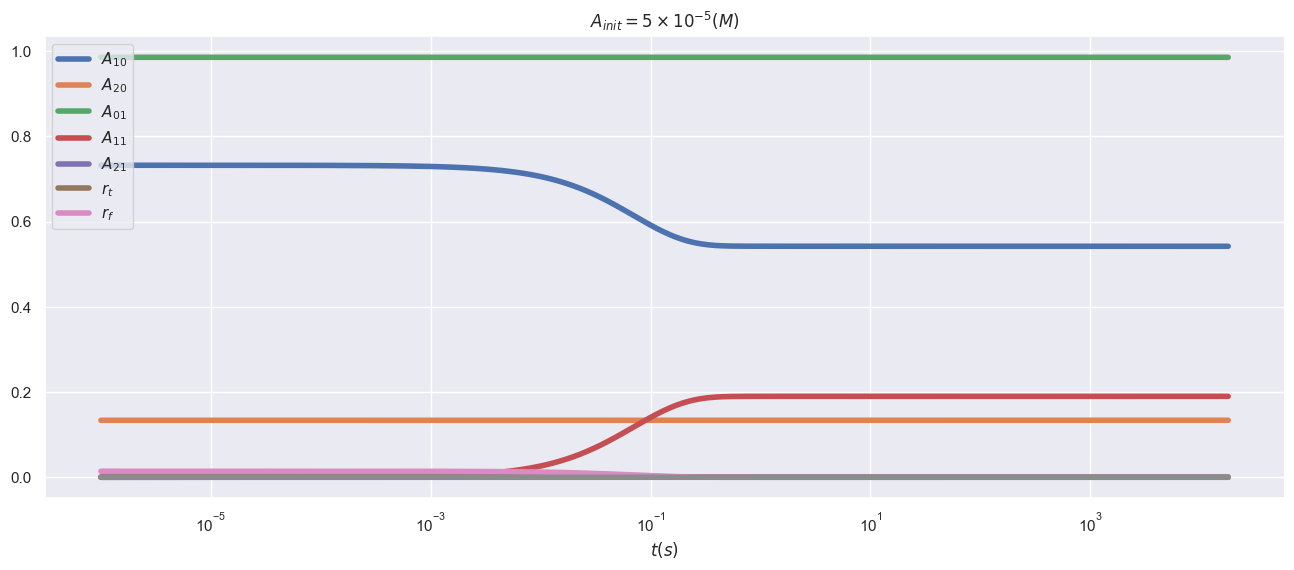

In [398]:
sns.set_theme()
rt = rtot_synapse- A10 - A11 - 2*(A20 + A21)
rf = rtot_fc_synapse - A01 - (A11 + A21)
A00 = (Atot - A10 - A20 - A01 - A11 - A21)/rtot_synapse
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(t, A10/rtot_synapse, lw=4,label = r'$A_{10}$')
ax.plot(t, A20/rtot_synapse, lw=4,label = r'$A_{20}$')
ax.plot(t, A01/rtot_fc_synapse, lw=4,label = r'$A_{01}$')
ax.plot(t, A11/rtot_synapse, lw=4,label = r'$A_{11}$')
ax.plot(t, A21/rtot_synapse, lw=4,label = r'$A_{21}$')
ax.plot(t, rt/rtot_synapse, lw=4, label = r'$r_t$')
ax.plot(t, rf/rtot_fc_synapse, lw=4, label = r'$r_f$')
ax.plot(t, A00, lw=4) 
print(A11[-1]/A21[-1])
plt.title(r'$A_{init} = 5 \times 10^{-5} (M)$')
plt.xscale('log')
plt.xlabel(r'$t (s)$')
plt.legend(loc='upper left')
plt.show()


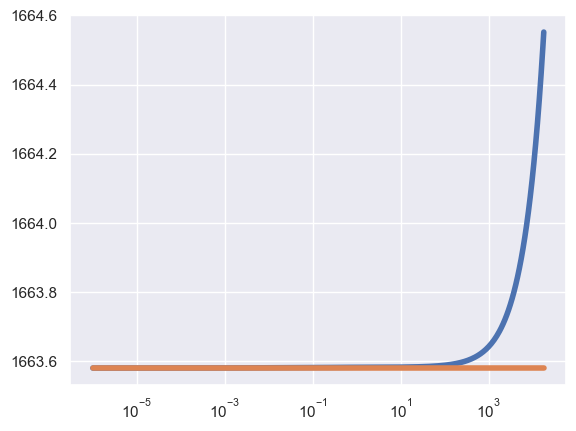

In [399]:
#plt.semilogx(t, rf, lw=4,label = r'$A_{01}$')
plt.semilogx(t, A21+A20, lw=4)
plt.semilogx(t, (A20[0] + A21[0])*np.ones_like(t), lw=4)
#plt.semilogx(t, A10/(A10 + A20), lw=4)
plt.show()

In [400]:
array = [A10[-1], A20[-1], A01[-1], A11[-1], A21[-1]]
vals = S_two_cells(0, array, k1, k2, k3, k4, k5, k6, k7, koff, qoff, rtot_synapse, rtot_fc_synapse, Atot)
print(vals)

[-5.1639698051886285e-05, -2.797168711021877, 5.301801635088088e-05, -5.183192001279386e-05, 2.797220339245273]


In [401]:
print(A11[-1]/rtot_synapse)
A1_st = fsolve(A1_steady_state, [1e-2], args=(A01_IC, k6, koff, k7, rtot_synapse - A10_IC - A20_IC))
A1_st1 = fsolve(A1_steady_state, [1e-2], args=(A10_IC + A20_IC + A01_IC, k6, koff, k7, rtot_synapse))
print((A1_st1)/rtot_synapse)

0.19001756269290068
[0.9954655]


In [402]:
rtot = 1e4
kon = 1e6
rtot_synapse = rtot*tumour_cell_IS_proportion
rtot_fc_synapse = rtot_fc*NK_cell_IS_proportion
target_effective_conc5 = (rtot_synapse)*((math.pi*(r_ab**2)/2)/(synapse_width**2))*(1/N_A)/(reaction_volume_4)
k7 = target_effective_conc5*kon/rtot_synapse
print(6.5e3/sigma_synapse)


863.4803149304


In [403]:
t_end = 60*60*1000
t = np.geomspace(1e-10, t_end, 500)
tspan = [1e-10, t_end]
A0s = np.geomspace(1e-12, 1e-4, 75)
rtots = [1e4, 1e5, 1e6]
qons = [6.5e3]
A10rs = np.zeros((len(rtots), len(A0s)))
A20rs = np.zeros((len(rtots), len(A0s)))
A01rs = np.zeros((len(rtots), len(A0s)))
A11rs = np.zeros((len(rtots), len(A0s)))
A21rs = np.zeros((len(rtots), len(A0s)))
rtot = 1e5
for j, qon in enumerate(qons):
    """
    D_t = 1e-14
    D_f = 7.4e-14
    kon=1e5
    rtot_synapse = rtot*tumour_cell_IS_proportion
    rtot_fc_synapse = rtot_fc*NK_cell_IS_proportion
    k1 = kon/sigma_synapse
    k3 = qon/sigma_synapse
    k2 = 4*D_t/(tumour_cell_surface_area)
    k4 = 4*D_f/(NK_cell_surface_area)   
    """

    target_effective_conc =(rtot)*((math.pi*(r_ab**2))/(tumour_cell_surface_area))*(1/N_A)/(reaction_volume1)
    k2_single = target_effective_conc*kon   
    rtot_synapse = rtot*tumour_cell_IS_proportion

    k1 = kon/sigma_synapse
    k3 = qon/sigma_synapse

    target_effective_conc1 =(rtot_synapse)*((math.pi*(r_ab**2))/(synapse_width**2))*(1/N_A)/(reaction_volume1)
    k2 = target_effective_conc1*kon

    target_effective_conc2 = (rtot_fc_synapse)*((math.pi*((2*r_ab)**2))/(synapse_width**2))*(1/N_A)/(reaction_volume3)
    k4 = target_effective_conc2*qon

    target_effective_conc3 = (rtot_fc_synapse)*((math.pi*(r_ab**2))/(synapse_width**2))*(1/N_A)/(reaction_volume1)
    k5 = target_effective_conc3*qon

    target_effective_conc4 = (rtot_synapse)*((math.pi*((r_ab)**2))/(synapse_width**2))*(1/N_A)/(reaction_volume3)
    k6 = target_effective_conc2*kon

    target_effective_conc5 = (rtot_synapse)*((math.pi*(r_ab**2)/2)/(synapse_width**2))*(1/N_A)/(reaction_volume_4)
    k7 = target_effective_conc5*kon
    for i, Ainit in enumerate(A0s):
        print(i)
        z0 = [0, 0]
        z = solve_ivp(R_single_cell, tspan, z0, method='BDF', t_eval=t, args=(Ainit, rtot, kon, k2_single, koff))

        Atot_whole = well_size*N_A*Ainit/Target_cell_number
        A1 = z.y[0]
        A2 = z.y[1]

        Atot_NK = (Atot_whole - A1[-1] - A2[-1])/E_T_ratio

        z = solve_ivp(NK_cell_model, tspan, [0], method='BDF', t_eval=t, args=(qon, qoff, rtot_fc, Atot_NK, E_T_ratio))

        A01 = z.y[0]

        A01_IC = A01[-1]*NK_cell_IS_proportion
        A10_IC = A1[-1]*tumour_cell_IS_proportion
        A20_IC = A2[-1]*tumour_cell_IS_proportion

        #Atot = A10_IC + A20_IC + A01_IC
        Atot = A10_IC + A20_IC 
        z0 = [A10_IC, A20_IC, 0, 0, 0]
    
        z = solve_ivp(R_two_cells, tspan, z0, method='BDF', atol = 1e-5, rtol = 1e-5, t_eval=t, args=(k1, k2, k3, k4, k5, k6, k7, koff, qoff, rtot_synapse, rtot_fc_synapse, Atot))
        print(z.message)
        A10 = z.y[0]
        A20 = z.y[1]
        A01 = z.y[2]
        A11 = z.y[3]
        A21 = z.y[4]

        A10rs[j][i] = A10[-1]
        A20rs[j][i] = A20[-1]
        A01rs[j][i] = A01[-1]
        A11rs[j][i] = A11[-1]
        A21rs[j][i] = A21[-1]

0
The solver successfully reached the end of the integration interval.
1
The solver successfully reached the end of the integration interval.
2
The solver successfully reached the end of the integration interval.
3
The solver successfully reached the end of the integration interval.
4
The solver successfully reached the end of the integration interval.
5
The solver successfully reached the end of the integration interval.
6
The solver successfully reached the end of the integration interval.
7
The solver successfully reached the end of the integration interval.
8
The solver successfully reached the end of the integration interval.
9
The solver successfully reached the end of the integration interval.
10
The solver successfully reached the end of the integration interval.
11
The solver successfully reached the end of the integration interval.
12


The solver successfully reached the end of the integration interval.
13
The solver successfully reached the end of the integration interval.
14
The solver successfully reached the end of the integration interval.
15
The solver successfully reached the end of the integration interval.
16


KeyboardInterrupt: 

In [ ]:
sns.set_theme()
sns.set_context('talk')
"""
plt.plot(A0s, A10rs/rtot_synapse, label = r'$A_{10}$')
plt.plot(A0s, A20rs/rtot_synapse, label = r'$A_{20}$')
plt.plot(A0s, A01rs/rtot_fc_synapse, label = r'$A_{01}$')
plt.plot(A0s, A11rs/rtot_synapse, label = r'$A_{11}$')
plt.plot(A0s, A21rs/rtot_synapse, label = r'$A_{21}$')


plt.xscale('log')
plt.legend(loc='best')
plt.show()
"""

"\nplt.plot(A0s, A10rs/rtot_synapse, label = r'$A_{10}$')\nplt.plot(A0s, A20rs/rtot_synapse, label = r'$A_{20}$')\nplt.plot(A0s, A01rs/rtot_fc_synapse, label = r'$A_{01}$')\nplt.plot(A0s, A11rs/rtot_synapse, label = r'$A_{11}$')\nplt.plot(A0s, A21rs/rtot_synapse, label = r'$A_{21}$')\n\n\nplt.xscale('log')\nplt.legend(loc='best')\nplt.show()\n"

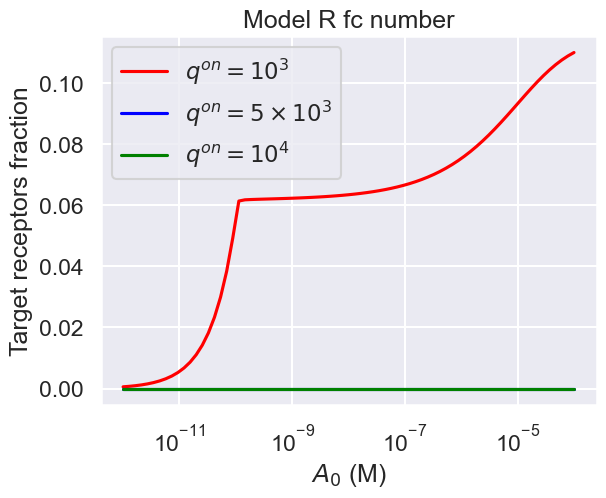

In [ ]:
labels = [r'$q^{on} = 10^3$', r'$q^{on} = 5 \times 10^3$', r'$q^{on} = 10^4$']
colors = ['red', 'blue', 'green']

for i, label in enumerate(labels):
    plt.plot(A0s, (A11rs[i][:] + A21rs[i][:])/rtot, label=label, c=colors[i])

plt.xscale('log')
plt.title('Model R fc number')
plt.legend(loc='best')
plt.xlabel(r'$A_0$ ' + '(M)')
plt.ylabel('Target receptors fraction')
plt.show()

In [ ]:
t_end = 60*60*1000
t = np.geomspace(1e-10, t_end, 1000)
tspan = [1e-10, t_end]
A0s = np.geomspace(1e-12, 1e-4, 75)
rtots = [1e4, 1e5, 1e6]

A10ss = np.zeros((len(rtots), len(A0s)))
A20ss = np.zeros((len(rtots), len(A0s)))
A01ss = np.zeros((len(rtots), len(A0s)))
A11ss = np.zeros((len(rtots), len(A0s)))
A21ss = np.zeros((len(rtots), len(A0s)))
kon = 1e5
koff = 1e-4
qoff = 4.7e-3
rtot_fc = 2.2e5
rtot = 1e5
k1 = kon/sigma_synapse
k3 = qon/sigma_synapse
synapse_area = synapse_width**2
for j, qon in enumerate(qons):
    k1 = kon/sigma_synapse
    k3 = qon/sigma_synapse  
    D_t = 1e-14
    D_f = 7.4e-14
    kon = 1e5
    koff = 1e-4
    rtot_synapse = rtot*tumour_cell_IS_proportion
    rtot_fc_synapse = rtot_fc*NK_cell_IS_proportion
    k1 = kon/sigma_synapse
    k3 = qon/sigma_synapse
    k2 = 4*D_t/(synapse_area)
    k2_single = 4*D_t/(tumour_cell_surface_area)
    k4 = 2*(D_t +D_f)/(synapse_area)   
    k5 = 2*(D_t +D_f)/(synapse_area)  
    k6 = 2*(D_t +D_f)/(synapse_area)  
    k7 = 2*D_t/synapse_area
    
    for i, Ainit in enumerate(A0s):
        print(i)
        z0 = [0, 0]
        z = solve_ivp(S_single_cell, tspan, z0, method='BDF', t_eval=t, args=(Ainit, rtot, kon, k2_single, koff))

        Atot_whole = well_size*N_A*Ainit/Target_cell_number
        A1 = z.y[0]
        A2 = z.y[1]

        Atot_NK = (Atot_whole - A1[-1] - A2[-1])/E_T_ratio

        z = solve_ivp(NK_cell_model, tspan, [0], method='BDF', t_eval=t, args=(qon, qoff, rtot_fc, Atot_NK, E_T_ratio))

        A01 = z.y[0]

        A01_IC = A01[-1]*NK_cell_IS_proportion
        A10_IC = A1[-1]*tumour_cell_IS_proportion
        A20_IC = A2[-1]*tumour_cell_IS_proportion

        Atot = A10_IC + A20_IC + A01_IC
        #Atot = A10_IC + A20_IC 
        print(Atot)
        z0 = [A10_IC, A20_IC, A01_IC, 0, 0]
    
        z = solve_ivp(S_two_cells, tspan, z0, method='BDF', atol=1e-5, rtol = 1e-5,  t_eval=t, args=(k1, k2, k3, k4, k5, k6, k7, koff, qoff, rtot_synapse, rtot_fc_synapse, Atot))
        print(z.message)
        A10 = z.y[0]
        A20 = z.y[1]
        A01 = z.y[2]
        A11 = z.y[3]
        A21 = z.y[4]
    

        A10ss[j][i] = A10[-1]
        A20ss[j][i] = A20[-1]
        A01ss[j][i] = A01[-1]
        A11ss[j][i] = A11[-1]
        A21ss[j][i] = A21[-1]

0
56.15421489549958
The solver successfully reached the end of the integration interval.
1
72.02615593307898
The solver successfully reached the end of the integration interval.
2
92.3842799412829
The solver successfully reached the end of the integration interval.
3
118.49658637703732
The solver successfully reached the end of the integration interval.
4
151.98947400174532
The solver successfully reached the end of the integration interval.
5
194.94900332831304
The solver successfully reached the end of the integration interval.
6
250.05086299768072
The solver successfully reached the end of the integration interval.
7
320.72694732865193
The solver successfully reached the end of the integration interval.
8
411.3790859003177
The solver successfully reached the end of the integration interval.
9
527.653076583358
The solver successfully reached the end of the integration interval.
10
676.7905216233493
The solver successfully reached the end of the integration interval.
11
868.0780964806

KeyboardInterrupt: 

In [ ]:
D_t = 1e-13
k6 = 2*(D_t +D_f)/(synapse_area)  
k7 = 2*D_t/synapse_area
print(k6, k7)

0.0034799999999999996 0.0019999999999999996


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


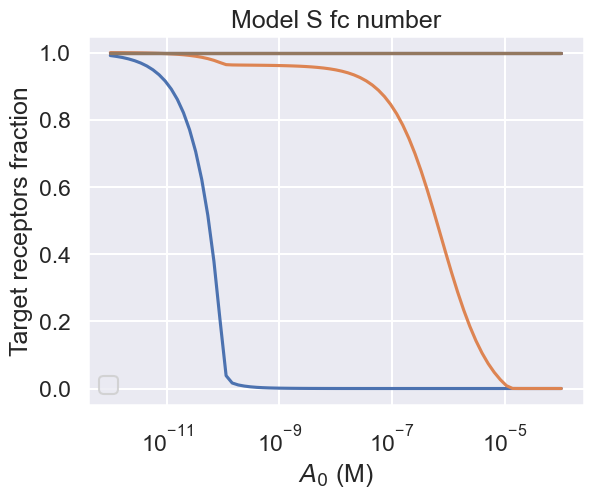

In [ ]:
labels = [r'$q^{on} = 10^3$', r'$q^{on} = 5 \times 10^3$', r'$q^{on} = 10^4$']
colors = ['red', 'blue', 'green']


for i, label in enumerate(labels):
    rt = rtot_synapse- A10ss[i][:] - A11ss[i][:] - 2*(A20ss[i][:] + A21ss[i][:])
    rf = rtot_fc_synapse - A01ss[i][:] - (A11ss[i][:] + A21ss[i][:])
    #plt.plot(A0s, A11ss[i][:]/rtot + A21ss[i][:]/rtot, label=label, c=colors[i])
    plt.plot(A0s, rt/rtot_synapse)
    plt.plot(A0s, rf/rtot_fc_synapse)

plt.xscale('log')
plt.title('Model S fc number')
plt.legend(loc='best')
plt.xlabel(r'$A_0$ ' + '(M)')
plt.ylabel('Target receptors fraction')
plt.show()